In [ ]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
import tensorflow as tf
import keras
from keras.layers import Bidirectional, LSTM
from keras.models import Sequential
from keras.preprocessing import text
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# **Upload Data**

In [ ]:
quipper_df = pd.read_csv('https://raw.githubusercontent.com/Syamsyuriani/Scrapping_Data/main/Quipper-Data_labelled.csv')

In [ ]:
quipper_df.columns

Index(['review', 'label', 'Unnamed: 2', 'Unnamed: 3'], dtype='object')

In [ ]:
review = quipper_df.drop(columns=['Unnamed: 2', 'Unnamed: 3'])
review

,review,label
0,Apk Quipper sangat membantu dalam memahami pel...,-1
1,"Penjelasannya bagus, tutornya juga enak ngejel...",-1
2,"Tolong dong quipper, saya lagi ngerjain soal a...",-1
3,"Banyak bug. klo matematika, fisika, kimia ,Jaw...",-1
4,"Aplikasinya kurang menarik, pembahasan nya lam...",-1
...,...,...
4885,Bagus sekali bisa belajar dengan mudah,1
4886,Sangat bagus untuk belajar di manapun dan kapa...,1
4887,Untuk orang yg berminat,1
4888,"Keren, sangat membantu siswa",1


In [ ]:
# Menghapus duplikat
dt = review.drop_duplicates(subset=['review'], keep='last', inplace=False).reset_index()
df = dt.drop(['index'], axis=1)
df

,review,label
0,Apk Quipper sangat membantu dalam memahami pel...,-1
1,"Penjelasannya bagus, tutornya juga enak ngejel...",-1
2,"Tolong dong quipper, saya lagi ngerjain soal a...",-1
3,"Banyak bug. klo matematika, fisika, kimia ,Jaw...",-1
4,"Aplikasinya kurang menarik, pembahasan nya lam...",-1
...,...,...
3906,Bagus sekali bisa belajar dengan mudah,1
3907,Sangat bagus untuk belajar di manapun dan kapa...,1
3908,Untuk orang yg berminat,1
3909,"Keren, sangat membantu siswa",1


In [ ]:
df['label'].value_counts()

-1    2210
 1    1701
Name: label, dtype: int64

Text(0.5, 1.0, 'Diagram Lingkaran Data Analisis Sentimen')

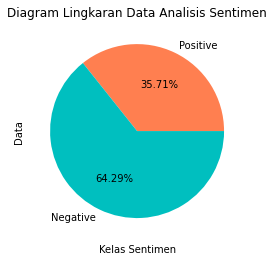

In [ ]:
labels = ['Positive','Negative']
Category1 = ['1701','3063']
plt.pie(Category1, labels=labels, autopct='%1.2f%%', colors=['coral', 'c'])
plt.xlabel('Kelas Sentimen')
plt.ylabel('Data')
plt.title('Diagram Lingkaran Data Analisis Sentimen')

Text(0.5, 1.0, 'Diagram Bar Data Analisis Sentimen')

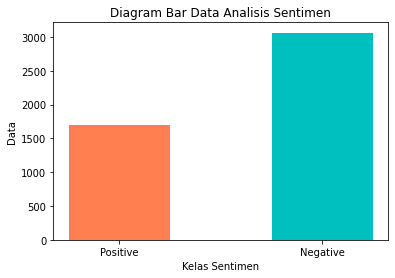

In [ ]:
labels = ['Positive','Negative']
Category1 = [1701, 3063]
plt.bar(labels, Category1, tick_label=labels, width=0.5, color=['coral', 'c'])
plt.xlabel('Kelas Sentimen')
plt.ylabel('Data')
plt.title('Diagram Bar Data Analisis Sentimen')

# ***Pre-processing***

In [ ]:
#PEMBERSIHAN(CLEANING DATA)
stopwords = pd.read_csv("https://raw.githubusercontent.com/listakurniawati/COVID-19-With-SVM/main/stopwords_id.csv?token=ARCQD7EZ55J4TUTAWYYLYOTAX3FTW")
stopwords = np.append(stopwords, "rt")
 
def clean_text(tweet):
 
    # Convert to lower case
    tweet = tweet.lower()
    # Clean www.* or https?://*
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet)
    # Clean @username
    tweet = re.sub('@[^\s]+','',tweet)
    #Remove punctuation
    tweet = re.sub(r'[^\w\s]',' ', tweet)
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    #Remove punctuation
    tweet = re.sub(r'[^\w\s]',' ', tweet)
    #Clean number
    tweet = re.sub(r'[\d-]', '', tweet)
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    #trim
    tweet = tweet.strip('\'"')
    # Clean per Words
    words = tweet.split()
    tokens=[]
    for ww in words:
        #split repeated word
        for w in re.split(r'[-/\s]\s*', ww):
            #replace two or more with two occurrences
            pattern = re.compile(r"(.)\1{1,}", re.DOTALL)
            w = pattern.sub(r"\1\1", w)
            #strip punctuation
            w = w.strip('\'"?,.')
            #check if the word cosists of two or more alphabets
            val = re.search(r"^[a-zA-Z][a-zA-Z][a-zA-Z]*$", w)
            #add tokens
            if(w in stopwords or val is None):
                continue
            else:
                tokens.append(w.lower())
    
    tweet = " ".join(tokens)
    return tweet

In [ ]:
df['label'] = df['label'].replace(-1,0)

In [ ]:
df['review'] = df['review'].map(lambda x: clean_text(x))
df = df[df['review'].apply(lambda x: len(x.split()) >=1)]
df

,review,label
0,apk quipper membantu memahami pelajaran solusi...,0
1,penjelasannya bagus tutornya enak ngejelasinny...,0
2,tolong quipper ngerjain tryout aplikasi koneks...,0
3,bug klo matematika fisika kimia fail loaded,0
4,aplikasinya menarik pembahasan nya banget gak ...,0
...,...,...
3906,bagus belajar mudah,1
3907,bagus belajar manapun,1
3908,orang yg berminat,1
3909,keren membantu siswa,1


In [ ]:
#tokenisasi
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df['review'])

In [ ]:
sequences = tokenizer.texts_to_sequences(df['review'])
x = keras.preprocessing.sequence.pad_sequences(sequences, maxlen=80)
y = np.array((df['label']))

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 42)

In [ ]:
seq_length = x.shape[1]
print(seq_length)
vocab_size = len(tokenizer.index_word) + 1
print(vocab_size)

80
5127


# **Model CNN BiLSTM**

In [ ]:
pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 3.5MB/s 


In [ ]:
from tensorflow import keras
from kerastuner.tuners import BayesianOptimization

def cnn_bilstm(hp):

    ### Arsitektur

    #Input layer
    inputs = keras.layers.Input(shape=(seq_length,))

    #Embedding
    embedding = keras.layers.Embedding(input_dim = vocab_size,
                                       output_dim = hp.Choice('embedding_size', values = [64, 100]))(inputs)

    #Convolution layer
    ngram_1 = keras.layers.Conv1D(filters = hp.Int('filters',
                                                min_value = 32, 
                                                max_value = 512, 
                                                step = 32),
                                  kernel_size = hp.Int('kernel_size',
                                                min_value = 2, 
                                                max_value = 5, 
                                                step = 1),
                                  activation='relu',
                                  kernel_regularizer = keras.regularizers.l2(hp.Choice('kernel_cnn',
                                                                                       values = [0.0, 0.01])))(embedding)
    ngram_2 = keras.layers.Conv1D(filters = hp.Int('filters',
                                                min_value = 32, 
                                                max_value = 512, 
                                                step = 32),
                                  kernel_size = hp.Int('kernel_size',
                                                min_value = 2, 
                                                max_value = 5, 
                                                step = 1),
                                  activation='relu',
                                  kernel_regularizer = keras.regularizers.l2(hp.Choice('kernel_cnn',
                                                                                       values = [0.0, 0.01])))(embedding)
    ngram_3 = keras.layers.Conv1D(filters = hp.Int('filters',
                                                min_value = 32, 
                                                max_value = 512, 
                                                step = 32),
                                  kernel_size = hp.Int('kernel_size',
                                                min_value = 2, 
                                                max_value = 5, 
                                                step = 1),
                                  activation='relu',
                                  kernel_regularizer = keras.regularizers.l2(hp.Choice('kernel_cnn',
                                                                                       values = [0.0, 0.01])))(embedding)
    ngram_4 = keras.layers.Conv1D(filters = hp.Int('filters',
                                                min_value = 32, 
                                                max_value = 512, 
                                                step = 32),
                                  kernel_size = hp.Int('kernel_size',
                                                min_value = 2, 
                                                max_value = 5, 
                                                step = 1),
                                  activation='relu',
                                  kernel_regularizer = keras.regularizers.l2(hp.Choice('kernel_cnn',
                                                                                       values = [0.0, 0.01])))(embedding)

    #Max Pooling layer
    ngram_1 = keras.layers.GlobalMaxPooling1D()(ngram_1)
    ngram_2 = keras.layers.GlobalMaxPooling1D()(ngram_2)
    ngram_3 = keras.layers.GlobalMaxPooling1D()(ngram_3)
    ngram_4 = keras.layers.GlobalMaxPooling1D()(ngram_4)
    merged = keras.layers.Concatenate(axis=1)([ngram_1, ngram_2, ngram_3, ngram_4])

    #BiLSTM layer
    bilstm1 = keras.layers.Layer(LSTM(units = hp.Int('units',
                                                     min_value = 32,
                                                     max_value = 512,
                                                     step = 32),
                                      kernel_regularizer=keras.regularizers.l2(hp.Choice('kernel_regularizer',
                                                                                         values = [0.0, 0.01])),
                                      recurrent_regularizer=keras.regularizers.l2(hp.Choice('rec_regularizer',
                                                                                            values = [0.0, 0.01])),
                                      return_sequences = True))(merged)
    bilstm2 = keras.layers.Layer(LSTM(units = hp.Int('units',
                                                     min_value = 32,
                                                     max_value = 512,
                                                     step = 32),
                                      kernel_regularizer=keras.regularizers.l2(hp.Choice('kernel_regularizer',
                                                                                         values = [0.0, 0.01])),
                                      recurrent_regularizer=keras.regularizers.l2(hp.Choice('rec_regularizer',
                                                                                            values = [0.0, 0.01])),
                                      return_sequences = True, go_backwards=True))(bilstm1)
    
    #Dropout layer
    lstm_out = keras.layers.Dropout(0.25)(bilstm2)

    #Output layer
    output = keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=keras.regularizers.l2(hp.Choice('kernel_dense', values = [0.0, 0.01])))(lstm_out)
    model = keras.models.Model(inputs=inputs, outputs=output)

    model.compile(optimizer = keras.optimizers.Adam(
                              hp.Choice('learning_rate', 
                                        values = [1e-2, 1e-3, 1e-4])),
                              loss='binary_crossentropy',
                              metrics=['accuracy'])

    return model

tuner = BayesianOptimization(cnn_bilstm,
                             objective = 'val_accuracy', 
                             max_trials = 10,
                             directory = 'Hasil',
                             project_name = 'Sentimen_CNN-BiLSTM')

tuner.search(x_train, y_train, batch_size=32, epochs = 5, validation_data = (x_test, y_test))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]

print('\nThe hyperparameter search is complete. \nembedding_size:', best_hps.get('embedding_size'),
      '\nfilters:', {best_hps.get('filters')},
      '\nkernel_size:', best_hps.get('kernel_size'),
      '\nkernel_cnn:', best_hps.get('kernel_cnn'),
      '\nunit:', best_hps.get('units'),
      '\nkernel_regularizer:', best_hps.get('kernel_regularizer'),
      '\nrec_regularizer:', best_hps.get('rec_regularizer'),
      '\nkernel_dense:', best_hps.get('kernel_dense'),
      '\nLearning rate:', best_hps.get('learning_rate'))

Trial 10 Complete [00h 00m 17s]
val_accuracy: 0.8812903165817261

Best val_accuracy So Far: 0.8812903165817261
Total elapsed time: 00h 06m 43s
INFO:tensorflow:Oracle triggered exit
The hyperparameter search is complete. 
embedding_size: 64 
filters: {32} 
kernel_size: 5 
kernel_cnn: 0.0 
unit: 32 
kernel_regularizer: 0.01 
rec_regularizer: 0.01 
kernel_dense: 0.01 
Learning rate: 0.01


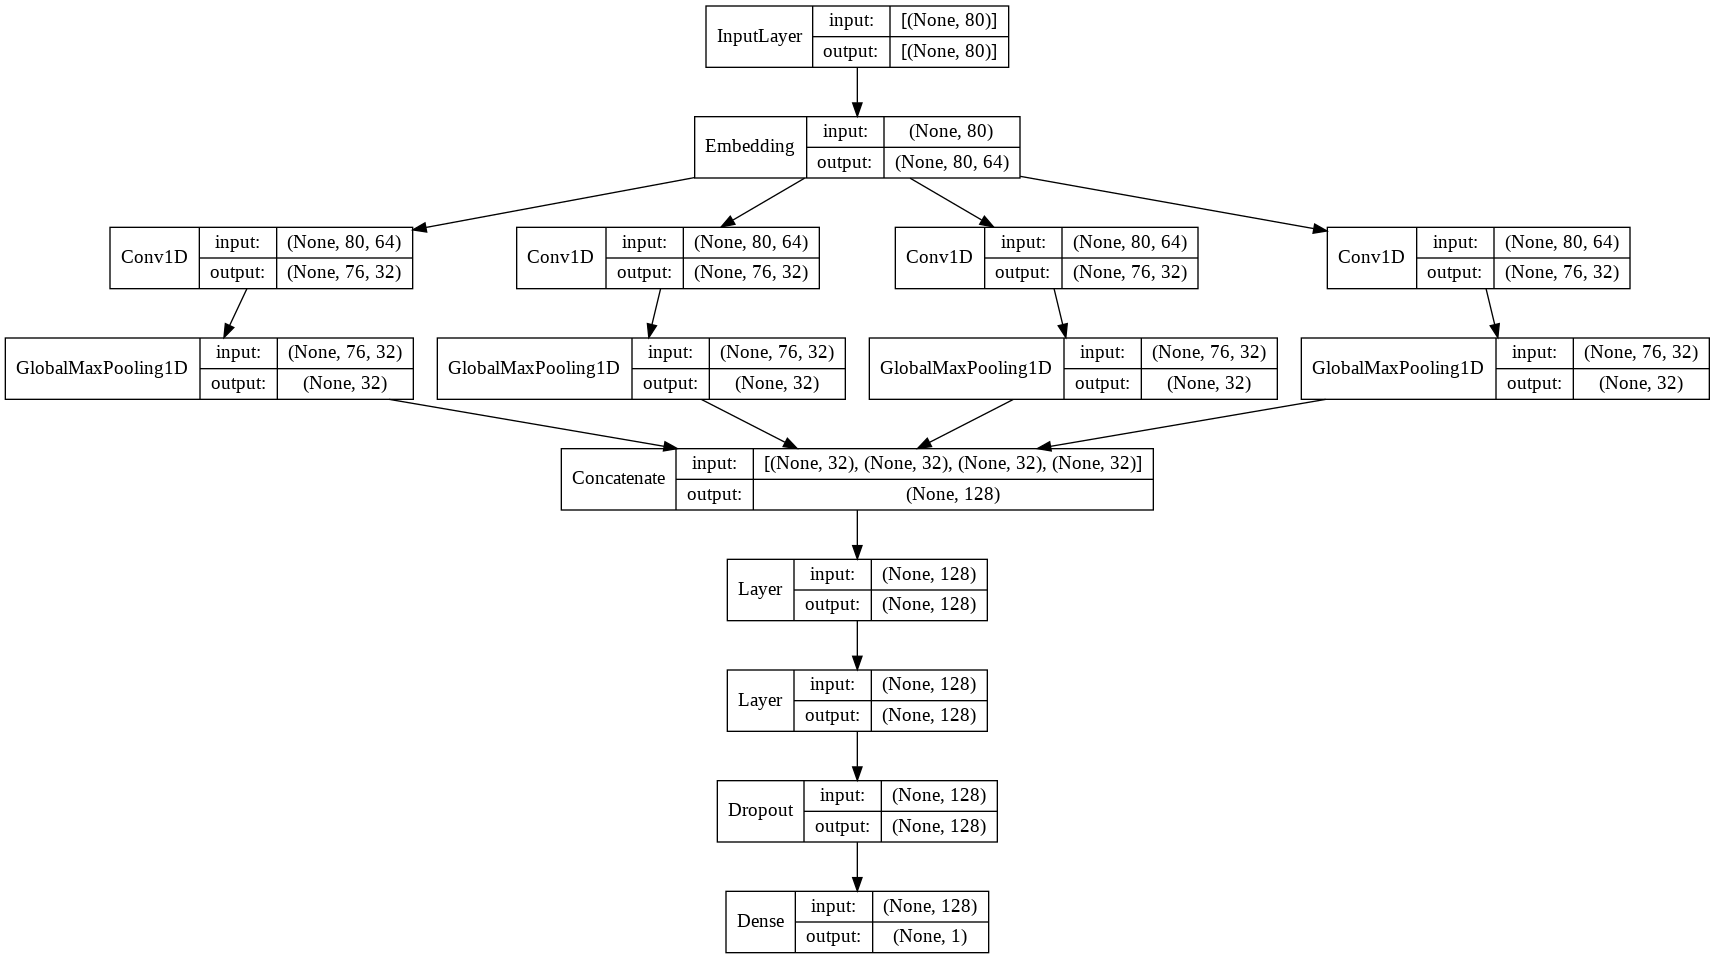

In [ ]:
from tensorflow.keras.utils import plot_model

model = tuner.hypermodel.build(best_hps)

#Plot Model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False, rankdir='TB')

In [ ]:
from keras.callbacks import EarlyStopping

# Retrain model with the optimal hyperparameters
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, batch_size=32, epochs = 50, validation_data = (x_test, y_test), callbacks=[early_stop])

Epoch 1/50
97/97 [==============================] - 4s 34ms/step - loss: 0.4229 - accuracy: 0.8165 - val_loss: 0.3305 - val_accuracy: 0.8529
Epoch 2/50
97/97 [==============================] - 3s 32ms/step - loss: 0.1742 - accuracy: 0.9458 - val_loss: 0.3827 - val_accuracy: 0.8516
Epoch 3/50
97/97 [==============================] - 3s 32ms/step - loss: 0.0951 - accuracy: 0.9706 - val_loss: 0.4915 - val_accuracy: 0.8413
Epoch 4/50
97/97 [==============================] - 3s 32ms/step - loss: 0.0689 - accuracy: 0.9813 - val_loss: 0.6129 - val_accuracy: 0.8555
Epoch 5/50
97/97 [==============================] - 3s 32ms/step - loss: 0.0487 - accuracy: 0.9852 - val_loss: 0.5435 - val_accuracy: 0.8568
Epoch 6/50
97/97 [==============================] - 3s 32ms/step - loss: 0.0394 - accuracy: 0.9881 - val_loss: 0.6111 - val_accuracy: 0.8581
Epoch 00006: early stopping


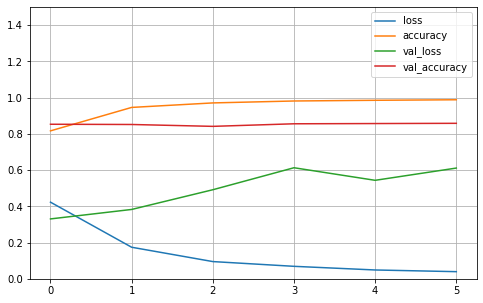

In [ ]:
# Plot grafik loss dan accuracy
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0,1.5)

plt.show()

In [ ]:
## Evaluasi Model
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

25/25 [==============================] - 0s 6ms/step - loss: 0.6111 - accuracy: 0.8581
Test accuracy: 0.8580645322799683


In [ ]:
## Penyimpanan Model
model.save('Data/model_CNN-BiLSTM_sentiment.h5')

# **Prediksi data baru**

In [ ]:
# Upload data yang akan diprediksi
new_data = pd.read_csv('https://raw.githubusercontent.com/Syamsyuriani/Scrapping_Data/main/Quipper-Data.csv')
new_data

,review
0,kalau bisa di perbarui lagi
1,KEREN!!!
2,"Kalo yang udah daftar terus di login pake facebook gampang,,, tapi kok quipper sekarang makin jelek"
3,Kode kelas tidak di temukan gimana nh min??? Dan untuk smk di tambah dong!!!!
4,"hai quipper video 😊 , saya ingin memberi masukan, lebih baik video yang sudah di unduh dan di si..."
...,...
1282,Gimana cara masukin soal?
1283,Amit jangan donwlod nyesel
1284,cari kode kelasnya dimanaaa..
1285,Harus bayar paketnya


In [ ]:
# Memuat kembali model
model = keras.models.load_model('Data/model_CNN-BiLSTM_sentiment.h5')

In [ ]:
# Tokenisasi dan pad sequencing
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(new_data['review'])
seq = tokenizer.texts_to_sequences(new_data['review'])
x_pred = keras.preprocessing.sequence.pad_sequences(seq, maxlen=80)
y_pred = model.predict(x_pred)

treshold = 0.5
for i in range(y_pred.shape[0]):
  if y_pred[i] > treshold:
    y_pred[i] = 1
  else:
    y_pred[i] = -1

new_data['label'] = y_pred

In [ ]:
# Hasil data yang telah diberi label
pd.set_option("max_colwidth", 100)
new_data

,review,label
0,kalau bisa di perbarui lagi,1.0
1,KEREN!!!,-1.0
2,"Kalo yang udah daftar terus di login pake facebook gampang,,, tapi kok quipper sekarang makin jelek",-1.0
3,Kode kelas tidak di temukan gimana nh min??? Dan untuk smk di tambah dong!!!!,-1.0
4,"hai quipper video 😊 , saya ingin memberi masukan, lebih baik video yang sudah di unduh dan di si...",-1.0
...,...,...
1282,Gimana cara masukin soal?,-1.0
1283,Amit jangan donwlod nyesel,1.0
1284,cari kode kelasnya dimanaaa..,-1.0
1285,Harus bayar paketnya,-1.0


In [ ]:
new_data['label'].value_counts()

-1.0    954
 1.0    333
Name: label, dtype: int64

Text(0.5, 1.0, 'Diagram Lingkaran Data Analisis Sentimen')

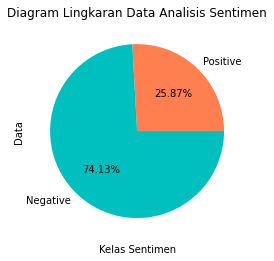

In [ ]:
labels = ['Positive','Negative']
Category1 = ['333','954']
plt.pie(Category1, labels=labels, autopct='%1.2f%%', colors=['coral', 'c'])
plt.xlabel('Kelas Sentimen')
plt.ylabel('Data')
plt.title('Diagram Lingkaran Data Analisis Sentimen')